## Experiments - Approximation algorithms for the Steiner tree problem on Graphs

In this Jupyter notebook, you will find the implementations of the following algorithms:
- A pre-built networkx approximation algorithm
- An enumeration algorithm that returns an optimal solution
- The Dreyfus-Wagner algorithm that returns an optimal solution
- A 2-approximate algorithm

Under every algorithm, there are several instances of the problem provided. To choose a specific instance, uncomment out the file_path as required.

### Imports

In [1]:
from networkx.algorithms import approximation
import networkx as nx
import matplotlib.pyplot as plt
import itertools
import copy
from collections import defaultdict
import time

### Helper functions

In [2]:
def parse_input_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    graph_section = False
    terminal_section = False
    G = nx.Graph()
    terminals = []
                
    for line in lines:
        line = line.strip().lower()

        if line == "section graph":
            graph_section = True
            continue
        elif line == "end" and graph_section:
            graph_section = False
            continue
        elif line == "section terminals":
            terminal_section = True
            continue
        elif line == "end" and terminal_section:
            terminal_section = False
            continue
        elif line == "eof":
            break

        if graph_section:
            if line.startswith("e "):
                _, node1, node2, weight = line.split()
                node1, node2, weight = int(node1), int(node2), int(weight)
                G.add_edge(node1, node2, weight=weight)

        if terminal_section:
            if line.startswith("t "):
                _, terminal = line.split()
                terminals.append(int(terminal))

    return G, terminals

def get_non_terminal_leaves(tree, terminals):

    if not nx.is_tree(tree):
        raise ValueError("The graph is not a tree")
    
    leaves = [node for node, degree in tree.degree() if degree == 1 and node not in terminals]
    
    return leaves

def draw_graph(G, terminals):
        
    #drawing of metric closure of subsets 
    steiner_nodes = list(set(G.nodes()) - set(terminals))
    node_attr = [('o', steiner_nodes, "lightgreen"),('s',terminals, "lightblue")]

    plt.figure(figsize=(8, 8))
    pos = nx.spring_layout(G)

    for shape, nodes, color in node_attr:
        nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_shape=shape, node_color=color, node_size=500)

    nx.draw_networkx_edges(G, pos)
    nx.draw_networkx_labels(G, pos)
    plt.show()
    
def remaining_elements(A, A1):
    set_A = frozenset(A)
    set_A1 = frozenset(A1)
    
    remaining_set = set_A - set_A1
    
    return remaining_set

def remove_duplicate_edges(edges):
    unique_edges = set()
    
    for edge in edges:
        # Sort the edge tuple to ensure (a, b) and (b, a) are treated as the same
        normalized_edge = tuple(sorted(edge))
        unique_edges.add(normalized_edge)
    
    # Convert the set back to a list of tuples
    return list(unique_edges)


def path_to_edges(path):
    edges = [set([path[i], path[i+1]]) for i in range(len(path) - 1)]
    return edges
    
def display_output(G, terminals, steiner_tree, total_weight, execution_time = None):

    print("Instance description")
    print("Graph Nodes:", len(G.nodes()))
    print("Graph Edges:", len(G.edges(data=True)))
    print("Terminal Set:", terminals)
    draw_graph(G, terminals)
    draw_graph(steiner_tree, terminals)
    print("Optimal edges = ", steiner_tree.edges)
    print("Total weight of Steiner tree:", total_weight)
    if execution_time:
        print(f"Execution time: {execution_time:.6f} seconds")

### Networkx approximate solution

C:\Users\Sakkir\AppData\Local\Temp\ipykernel_26592\1102812268.py:10: FutureWarning: steiner_tree will change default method from 'kou' to 'mehlhorn'in version 3.2.
Set the `method` kwarg to remove this warning.
  steiner_tree = approximation.steiner_tree(G, terminals, weight='weight', method=None)


Instance description
Graph Nodes: 80
Graph Edges: 350
Terminal Set: [1, 2, 3, 4, 5, 6]


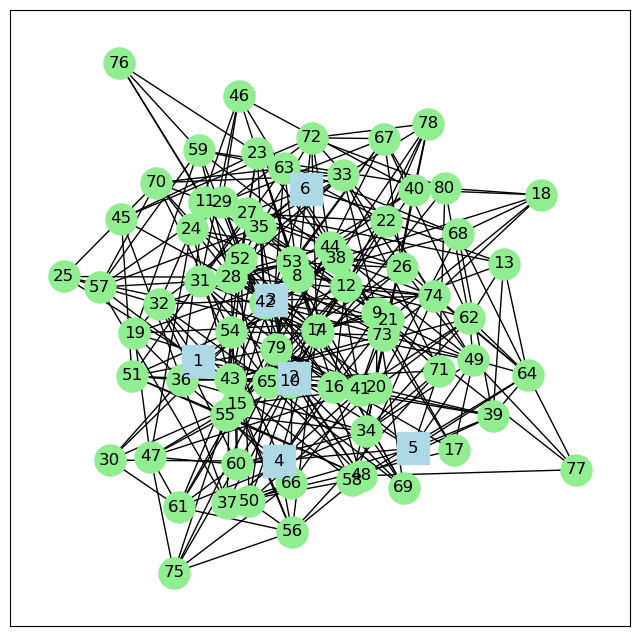

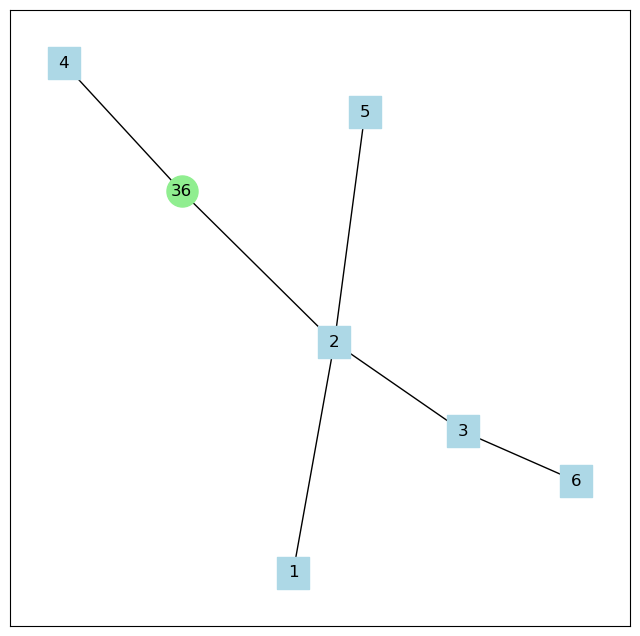

Optimal edges =  [(1, 2), (2, 3), (2, 5), (2, 36), (3, 6), (36, 4)]
Total weight of Steiner tree: 1602.0


In [3]:
# Choose instance of the problem by uncommenting the relevant file path

# file_path = 'datasets/Steiner_instance1.txt'  #n=53, e=80, t=4   
file_path = 'datasets/Steiner_instance2.txt' #n=80, e=350, t=6
# file_path = 'datasets/Steiner_instance3.txt' #n=100, e=4950, t=10   
# file_path = 'datasets/Steiner_instance4.txt' #n=320, e=1845, t=17
# file_path = 'datasets/Steiner_instance5.txt'  #n=320, e=480, t=17

G, terminals = parse_input_file(file_path)
steiner_tree = approximation.steiner_tree(G, terminals, weight='weight', method=None)
display_output(G, terminals, steiner_tree, steiner_tree.size(weight='weight'))

### Enumeration algorithm

Can handle small instance of the problem in reasonable time

Instance description
Graph Nodes: 53
Graph Edges: 80
Terminal Set: [1, 9, 40, 47]


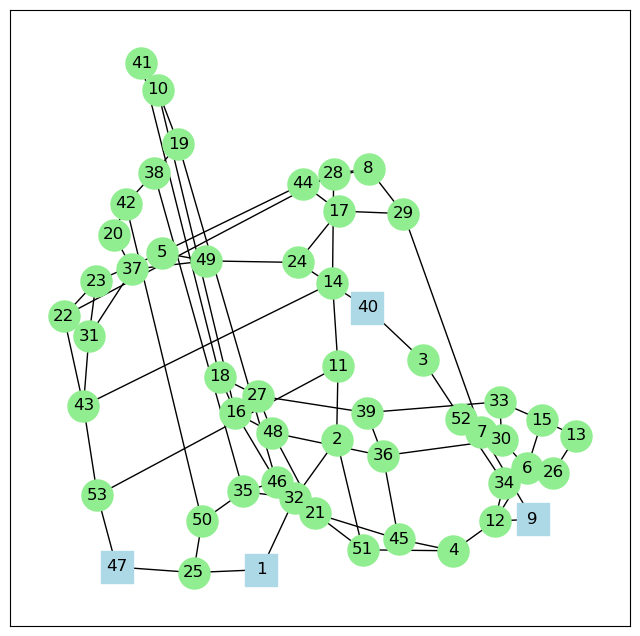

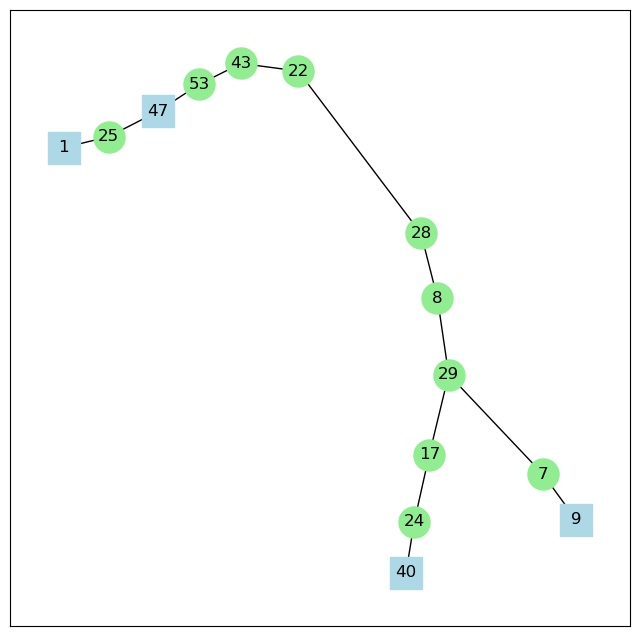

Optimal edges =  [(1, 25), (25, 47), (47, 53), (40, 24), (24, 17), (17, 29), (29, 7), (29, 8), (9, 7), (53, 43), (8, 28), (28, 22), (22, 43)]
Total weight of Steiner tree: 503.0
Execution time: 0.647506 seconds


In [4]:
def enumeration_algorithm_steiner_tree(G, terminals):
    
    start_time = time.time()
    metric_closure = approximation.metric_closure(G, weight='weight')

    Steiner_nodes = set(G.nodes()) - set(terminals)
    min_cost = float('inf')
    best_mst = None
    best_subgraph = None

    #cheapest mst among metric closure of subsets
    for i in range(0, len(terminals)-1):
        for S in itertools.combinations(Steiner_nodes, i):
            subset_nodes = set(terminals) | set(S)
            subgraph = metric_closure.subgraph(subset_nodes)
            
            mst = nx.minimum_spanning_tree(subgraph, weight = 'distance')
            cost = mst.size(weight='distance')
            if cost <= min_cost:
                best_subgraph = subgraph
                min_cost = cost
                best_mst = mst
                

    steiner_tree = nx.Graph()
    for u, v in best_mst.edges():
        path = metric_closure.edges[u, v]['path']
        nx.add_path(steiner_tree, path)

    for u, v in steiner_tree.edges():
        nx.set_edge_attributes(steiner_tree, {(u, v): {"weight": G.get_edge_data(u, v)['weight']}})
        
    for node in get_non_terminal_leaves(steiner_tree, terminals):
        steiner_tree.remove_node(node)
    

    end_time = time.time()
    elapsed_time = end_time - start_time
    return steiner_tree, steiner_tree.size(weight='weight'), terminals, elapsed_time


# Choose instance of the problem by uncommenting the relevant file path

file_path = 'datasets/Steiner_instance1.txt'  #n=53, e=80, t=4   
# file_path = 'datasets/Steiner_instance2.txt' #n=80, e=350, t=6
# file_path = 'datasets/Steiner_instance3.txt' #n=100, e=4950, t=10   
# file_path = 'datasets/Steiner_instance4.txt' #n=320, e=1845, t=17
# file_path = 'datasets/Steiner_instance5.txt'  #n=320, e=480, t=17

G, terminals = parse_input_file(file_path)
steiner_tree, total_weight, terminals, execution_time = enumeration_algorithm_steiner_tree(G, terminals)
display_output(G, terminals, steiner_tree, total_weight, execution_time)

### Dreyfus Wagner

Instance description
Graph Nodes: 100
Graph Edges: 4950
Terminal Set: [43, 97, 77, 73, 34, 50, 82, 40, 76, 79]


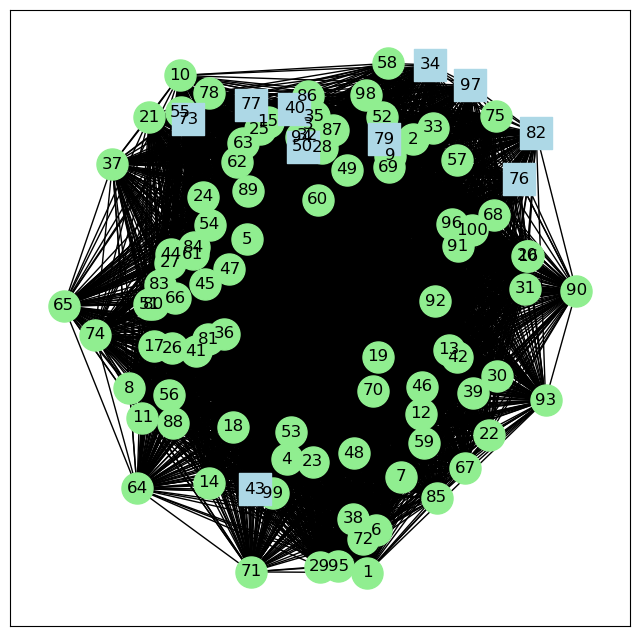

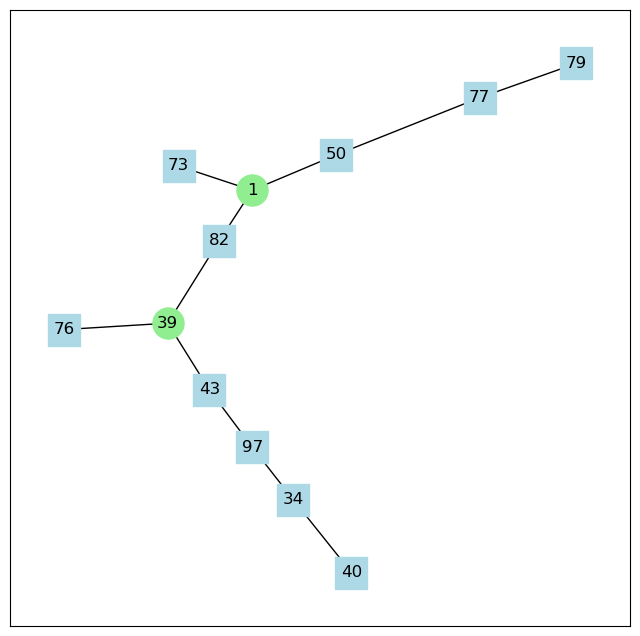

Optimal edges =  [(1, 73), (1, 82), (1, 50), (77, 79), (77, 50), (39, 76), (39, 82), (39, 43), (34, 97), (34, 40), (97, 43)]
Total weight of Steiner tree: 1609
Execution time: 11.163083 seconds


In [5]:
big_m = 99999999999999999999

def dreyfus_wagner(G, terminals):
    
    start_time = time.time()
    metric_closure = approximation.metric_closure(G, weight='weight')

    opt_data = defaultdict(lambda: defaultdict(list))
    #Optimal decomposition = Comp1 + Comp2 + Comp3
    Comp1 = terminals[0]
    C = terminals[1:].copy()
    C=tuple(C)
    
    for single_node in C:       
        for j in range(1, max(G.nodes)+1):
            shortest_distance = 0 if not metric_closure.get_edge_data(single_node, j) else metric_closure.get_edge_data(single_node, j)['distance']
            shortest_edges = [] if not metric_closure.get_edge_data(single_node, j) else path_to_edges(metric_closure.get_edge_data(single_node, j)['path'])
            if j==1:
                opt_data[1][frozenset([single_node])] = [[shortest_distance, shortest_edges]]
            else:
                opt_data[1][frozenset([single_node])].append([shortest_distance, shortest_edges])
    
    for m in range(2, len(C)):
        for D in list(itertools.combinations(C, m)):
            for i in range(1, max(G.nodes)+1):
                if i==1:
                    opt_data[m][frozenset(D)] = [[big_m,[]]]
                else:
                    opt_data[m][frozenset(D)].append([big_m,[]])
                    
            for j in range(1, max(G.nodes)+1):
                partition_sum = big_m
                
                for subset_size in range(len(D)-1):
                    for E in list(itertools.combinations(D[1:], subset_size)):
                        part1 = frozenset([D[0]] + list(E))
                        part2 = remaining_elements(D, part1)
                        current_partition_sum = opt_data[len(part1)][part1][j-1][0] + opt_data[len(part2)][part2][j-1][0]
                        if current_partition_sum < partition_sum:
                            partition_sum = current_partition_sum
                            partition_edges = opt_data[len(part1)][part1][j-1][1] + opt_data[len(part2)][part2][j-1][1]
                
                for i in range(1, max(G.nodes)+1):
                    cost_current_branch = partition_sum if not metric_closure.get_edge_data(i, j) else partition_sum + metric_closure.get_edge_data(i, j)['distance']
                    if cost_current_branch < opt_data[len(D)][frozenset(D)][i-1][0]:
                        opt_data[len(D)][frozenset(D)][i-1][0] = cost_current_branch
                        opt_data[len(D)][frozenset(D)][i-1][1] = [] if not metric_closure.get_edge_data(i, j) else path_to_edges(metric_closure.get_edge_data(i, j)['path'])
                        opt_data[len(D)][frozenset(D)][i-1][1] += partition_edges
                        
    opt = big_m
    for j in range(1, max(G.nodes)+1):
        partition_sum = big_m
        
        for subset_size in range(len(C)-1):
            for E in list(itertools.combinations(C[1:], subset_size)):
                part1 = frozenset([C[0]] + list(E))
                part2 = remaining_elements(C, part1)
                current_partition_sum = opt_data[len(part1)][part1][j-1][0] + opt_data[len(part2)][part2][j-1][0]
                if current_partition_sum < partition_sum:
                    partition_sum = current_partition_sum
                    partition_edges = opt_data[len(part1)][part1][j-1][1] + opt_data[len(part2)][part2][j-1][1]

        current_opt = partition_sum if not metric_closure.get_edge_data(Comp1, j) else partition_sum + metric_closure.get_edge_data(Comp1, j)['distance']
        if current_opt < opt:
            opt = current_opt
            opt_edges = [] if not metric_closure.get_edge_data(Comp1, j) else path_to_edges(metric_closure.get_edge_data(Comp1, j)['path'])
            opt_edges += partition_edges
    opt_edges = remove_duplicate_edges(opt_edges)
    
    total_weight = sum(G[u][v]['weight'] for u, v in opt_edges)
    
    steiner_tree = nx.Graph()
    steiner_tree.add_edges_from(opt_edges)
    
    for u, v in steiner_tree.edges():
        nx.set_edge_attributes(steiner_tree, {(u, v): {"weight": G.get_edge_data(u, v)['weight']}})
        
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    return steiner_tree, total_weight, terminals, elapsed_time
    
    
# Choose instance of the problem by uncommenting the relevant file path

# file_path = 'datasets/Steiner_instance1.txt'  #n=53, e=80, t=4   
# file_path = 'datasets/Steiner_instance2.txt' #n=80, e=350, t=6
file_path = 'datasets/Steiner_instance3.txt' #n=100, e=4950, t=10   
# file_path = 'datasets/Steiner_instance4.txt' #n=320, e=1845, t=17
# file_path = 'datasets/Steiner_instance5.txt'  #n=320, e=480, t=17 

G, terminals = parse_input_file(file_path)
steiner_tree, total_weight, terminals, execution_time = dreyfus_wagner(G, terminals)
display_output(G, terminals, steiner_tree, total_weight, execution_time)

### 2-approximate solution

Instance description
Graph Nodes: 80
Graph Edges: 350
Terminal Set: [1, 2, 3, 4, 5, 6]


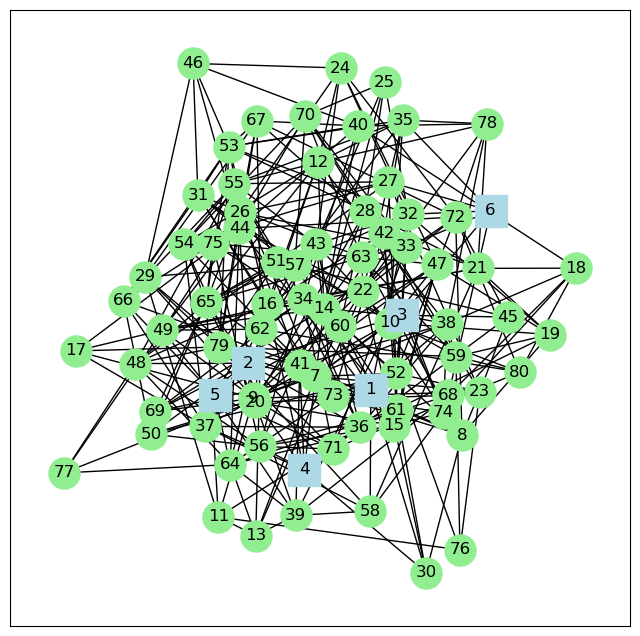

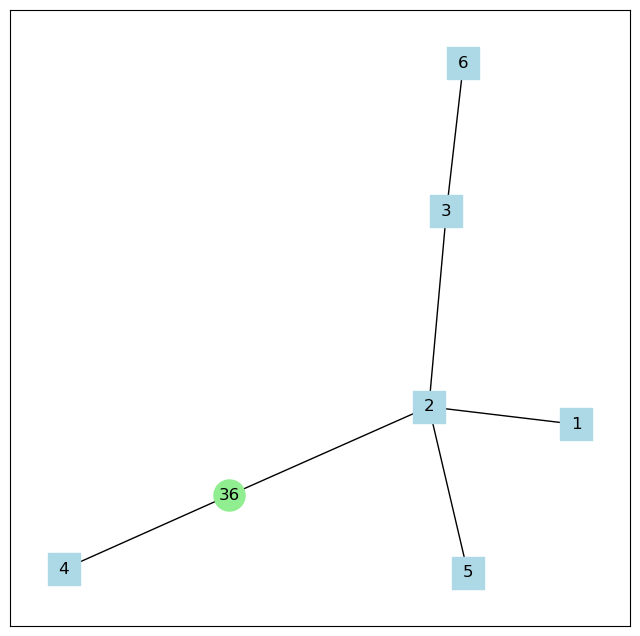

Optimal edges =  [(1, 2), (2, 3), (2, 5), (2, 36), (3, 6), (36, 4)]
Total weight of Steiner tree: 1602.0
Execution time: 0.007252 seconds


In [6]:
def terminal_metric_closure(G, terminals):
    metric_closure = nx.Graph()
    metric_closure.add_edges_from(list(itertools.combinations(terminals, 2)))
    
    for u, v in metric_closure.edges():
        shortest_path = nx.shortest_path(G, source=u, target=v, weight = 'weight')
        path_length = nx.shortest_path_length(G, source=u, target=v, weight = 'weight')
        metric_closure[u][v]['shortest_path'] = shortest_path
        metric_closure[u][v]['path_length'] = path_length
    
    return metric_closure

    
def approximation_2(G, terminals):
    start_time = time.time()
    metric_closure = terminal_metric_closure(G, terminals)
    mst = nx.minimum_spanning_tree(metric_closure, weight = 'path_length')
    steiner_tree = nx.Graph()
    for u, v in mst.edges():
        path = metric_closure.edges[u, v]['shortest_path']
        nx.add_path(steiner_tree, path)

    for u, v in steiner_tree.edges():
        nx.set_edge_attributes(steiner_tree, {(u, v): {"weight": G.get_edge_data(u, v)['weight']}})
        
    end_time = time.time()
    execution_time = end_time - start_time

    return steiner_tree, steiner_tree.size(weight='weight'), terminals, execution_time



# Choose instance of the problem by uncommenting the relevant file path

# file_path = 'datasets/Steiner_instance1.txt'  #n=53, e=80, t=4   
file_path = 'datasets/Steiner_instance2.txt' #n=80, e=350, t=6
# file_path = 'datasets/Steiner_instance3.txt' #n=100, e=4950, t=10   
# file_path = 'datasets/Steiner_instance4.txt' #n=320, e=1845, t=17
# file_path = 'datasets/Steiner_instance5.txt'  #n=320, e=480, t=17

G, terminals = parse_input_file(file_path)
steiner_tree, total_weight, terminals, execution_time = approximation_2(G, terminals)
display_output(G, terminals, steiner_tree, total_weight, execution_time)

## Final experiments

In [8]:
import networkx as nx
import pandas as pd
import time


def run_algorithm(algorithm_name, algorithm_function, G, terminals, optimal, file_path):
    
    if algorithm_name == "Networkx prebuilt":
        start_time = time.time()
        steiner_tree = algorithm_function(G, terminals)
        total_weight = sum(G[u][v]['weight'] for u, v in steiner_tree.edges())
        execution_time = time.time() - start_time

    else:
        steiner_tree, total_weight, terminals, execution_time = algorithm_function(G, terminals)

    return {
        'Instance': file_path[9:],
        'Nodes':len(G.nodes),
        'Edges':len(G.edges),
        'Terminals': len(terminals),
        'Algorithm': algorithm_name,
        'Optimal?': optimal,
        'Total_weight': total_weight,
        'Elapsed_time (s)': execution_time
    }

results = []

instances = [
    ('datasets/Steiner_instance1.txt', [True, True, True, True]),
    ('datasets/Steiner_instance2.txt', [True, False, True, True]),
    ('datasets/Steiner_instance3.txt', [True, False, True, True]),
    ('datasets/Steiner_instance4.txt', [True, False, False, True]),
    ('datasets/Steiner_instance5.txt', [True, False, False, True])
]

algorithms = [
    ("Networkx prebuilt", approximation.steiner_tree, False, [0, 1, 2, 3, 4]),
    ("Enumeration Algorithm", enumeration_algorithm_steiner_tree, True, [0]),
    ("Dreyfus Wagner", dreyfus_wagner, True, [0, 1, 2]),
    ("2-Approximation algorithm", approximation_2, False, [0, 1, 2, 3, 4])
]

for idx, (file_path, runs) in enumerate(instances):
    G, terminals = parse_input_file(file_path)
    
    for name, function, is_optimal, instance_ids in algorithms:
        if idx in instance_ids:
            result = run_algorithm(name, function, G, terminals, is_optimal, file_path)
            results.append(result)


df = pd.DataFrame(results)
display(df)
df.to_csv('steiner_tree_results.csv', index=False)


C:\Users\Sakkir\AppData\Local\Temp\ipykernel_26592\1649086810.py:50: FutureWarning: steiner_tree will change default method from 'kou' to 'mehlhorn'in version 3.2.
Set the `method` kwarg to remove this warning.
  result = run_algorithm(name, function, G, terminals, is_optimal, file_path)


,Instance,Nodes,Edges,Terminals,Algorithm,Optimal?,Total_weight,Elapsed_time (s)
0,Steiner_instance1.txt,53,80,4,Networkx prebuilt,False,503.0,0.015628
1,Steiner_instance1.txt,53,80,4,Enumeration Algorithm,True,503.0,0.580845
2,Steiner_instance1.txt,53,80,4,Dreyfus Wagner,True,503.0,0.032304
3,Steiner_instance1.txt,53,80,4,2-Approximation algorithm,False,503.0,0.000000
4,Steiner_instance2.txt,80,350,6,Networkx prebuilt,False,1602.0,0.062231
5,Steiner_instance2.txt,80,350,6,Dreyfus Wagner,True,1495.0,0.367042
6,Steiner_instance2.txt,80,350,6,2-Approximation algorithm,False,1602.0,0.010117
7,Steiner_instance3.txt,100,4950,10,Networkx prebuilt,False,1642.0,0.772684
8,Steiner_instance3.txt,100,4950,10,Dreyfus Wagner,True,1609.0,10.508172
9,Steiner_instance3.txt,100,4950,10,2-Approximation algorithm,False,1642.0,0.157300
